## CS 6120: Natural Language Processing - Prof. Ahmad Uzair

### Assignment 1: Naive Bayes
### Total Points: 100 points

You will be dealing with movie review data that includes both positive and negative reviews in this assignment. You will use Sentiment Analysis to assess if a given review is positive or negative using the provided dataset.

Therefore, we will make use of Naive Bayes algorithm to perform sentiment analysis on the movie review dataset.

## Importing the Libraries

In [103]:
import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

## Reading the data

When reading the data, ensure that the '.csv' file is in the same location where your jupyter notebook is used. This way the files are organized and easy to read using the pandas library. 

In [104]:
## Reading the data and removing columns that are not important. 
df = pd.read_csv("movie_reviews.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [105]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


## Count plot of the output categories: positive or negative

Feel free to take a look at the output and whether the classes are balanced or imbalanced. 

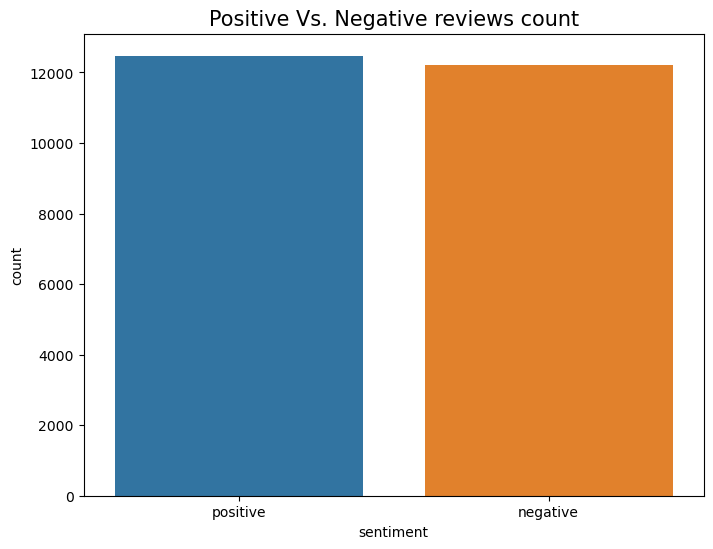

In [106]:
plt.figure(figsize = (8,6))
sns.countplot(data =df , x ='sentiment')
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()



## Upsampling the minority class: (5 points)

It is known that Naive bayes is not robust to class imbalance. It could be seen above that the data is little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction. 

Feel free to use 'resample' library from sklearn. 

In [107]:
## hint: use resample from sklearn.utils
from sklearn.utils import resample

df_majority = df[df['sentiment']=='positive']
df_minority = df[df['sentiment']=='negative']

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

df_upsampled = pd.concat([df_majority, negative_upsample])  # concat two data frames i,e majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)

In [108]:
## Just to ensure that upsampling was done successfully, take a look at the shape of the data in 
## this cell. 

# print the shape of data set with the help of shape function having "negative" as class label

df_upsampled[df_upsampled['sentiment']=='negative'].shape

(12474, 2)

### Expected Output : 
(12474, 2)

In [109]:
## Ensure that the same number of data points are present for both 'positive' and 'negative' data
df_upsampled[df_upsampled['sentiment']=='positive'].shape
# print the shape of data set with the help of shape function having "positive" as class label


(12474, 2)

In [110]:
df_upsampled.head()

,review,sentiment
8906,I haven't seen every single movie that Burt Re...,positive
11251,"Not since ""8 Heads in a Duffel Bag"" and the ""H...",negative
13099,"In ""Die Nibelungen: Siegfried"", Siegfried was ...",positive
22095,This movie looked fun on the cover and I hones...,negative
9579,I know the girl who did the figure skating for...,positive


### Expected Output : 
(12474, 2)

In [111]:
## In this cell, we are going to be dividing the data into train and test points
## Ensure that you store the upsampled data in a variable called 'df_upsampled' 
## so that the below operations are performed successfully


## Considering 10000 positive and 10000 negative data points
negative_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[:10000]

## Considering the remaining data points for test
negative_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'negative'].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled['sentiment'] == 'positive'].iloc[10000:]

## Concatenate the training positive and negative reviews
X_train = pd.concat([positive_data_points_train['review'],negative_data_points_train['review']])
## Concatenating the training positive and negative outputs
y_train = pd.concat([positive_data_points_train['sentiment'], negative_data_points_train['sentiment']])

## Concatenating the test positive and negative reviews
X_test = pd.concat([positive_data_points_test['review'], negative_data_points_test['review']])
## Concatenating the test positive and negative outputs
y_test = pd.concat([positive_data_points_test['sentiment'], negative_data_points_test['sentiment']])


In [112]:
## Take a look at the total number of classes and their count using '.value_counts()' for y_train and y_test.
## Ensure that there are equal number of positive and negative reviews. 
y_train.value_counts()
y_train

8906     positive
13099    positive
9579     positive
23890    positive
18297    positive
           ...   
16658    negative
3890     negative
7452     negative
12854    negative
9739     negative
Name: sentiment, Length: 20000, dtype: object

### Expected Output:
negative    10000<br>
positive    10000<br>
Name: sentiment, dtype: int64

In [113]:
y_test.value_counts()

positive    2474
negative    2474
Name: sentiment, dtype: int64

### Expected Output : 
negative    2474<br>
positive    2474<br>
Name: sentiment, dtype: int64

## Q1. Pre-process the reviews: (10 points)

We know that a review contains links, punctuation, stopwords and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. 

In the cell below, one must implement text-preprocessing and remove links, punctuations and stopwords. It is also important to lowercase the letters so that 'Admire' and 'admire' are not treated as different words. 

In addition to this, perform stemming operation so that similar words are reduced. To know more about stemming, feel free to take a look at this link.

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [114]:
# TASK CELL

def clean_review(review):
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review. 

    '''
    review = review.lower()

    # Use regex to keep only alphabetic characters
    review = re.sub(r'[^a-z ]', '', review)

    # Tokenize the review into words
    words = word_tokenize(review)

    # Remove stopwords
    words = [word for word in words if word not in stopwords.words("english")]

    # Join the cleaned words back into a single string
    review_cleaned = ' '.join(words)

    return review_cleaned

## Q2. Implement a find_occurrence function (5 points):

In this function, we find the total occurrence of a word giving information such as label, word and frequency dictionary.

Note that this function is used later in the code when we are going to be predicting the output using Naive Bayes. 

In [115]:
# TASK CELL
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    if (word,label) in frequency:
        return frequency[(word,label)]
    else:
        return 0

### Converting output to numerical format:

We have outputs as 'positive' or 'negative'. In the cell below, we convert it to a numerical format. 

In [116]:
## With the use of mapping function, we replace
## the label in the form of string to an integer. 

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [ ]:
y_train


In [117]:
## Ensuring that there are equal number of classes on the training data. 
y_train.value_counts()

0    10000
1    10000
Name: sentiment, dtype: int64

In [118]:
## Choosing a random review and taking a look at it.
X_train.iloc[0]

'I haven\'t seen every single movie that Burt Reynolds has ever made, but this one (which I\'ve just finished watching, for the third time) may very well be his best! It suffers only from some slow stretches; Burt perhaps tried to make it more "arty" than it should have been. On the other hand, he managed to avoid many of the usual cliches in the presentation of the "tough cop" role he plays (notice, for example, the scene in which he attempts to kiss Rachel Ward for the first time, or the fear he expresses just before the final showdown with the indestructible Henry Silva). In fact, Silva and those two ninja assassins are three of the most memorable villains of cop thrillers of the 80s. The film also has some offbeat touches, a surprising amount of humor, a brutal and gripping fistfight and many well-directed shots. (***)'

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. 

Therefore, those words would be removed. It also reduces the computation time. 

Therefore, it is a good practice we are following.

In [119]:
custom_review = X_train.iloc[0]

# print cleaned review
print(clean_review(custom_review))

havent seen every single movie burt reynolds ever made one ive finished watching third time may well best suffers slow stretches burt perhaps tried make arty hand managed avoid many usual cliches presentation tough cop role plays notice example scene attempts kiss rachel ward first time fear expresses final showdown indestructible henry silva fact silva two ninja assassins three memorable villains cop thrillers film also offbeat touches surprising amount humor brutal gripping fistfight many welldirected shots


We now use this function to pre-process the review and remove words that don't add a lot of meaning in our model. 

## Q3. Implementing review counter function: (5 points)

It is now time to implement the count function for the reviews. 

In this function, we count the occurrence of words and get the probabilities 
for the words based on the training data. 

In other words, we get the probability of occurrence of a word, given that the output is 'positive'.

Similarly, we also compute the probability of occurence of a word, given that the output is 'negative'.



In [120]:
# TASK CELL
def review_counter(output_occurrence, reviews, positive_or_negative):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
    
    for label, review in zip(positive_or_negative, reviews):
      split_review = clean_review(review).split()
      for word in split_review:
        if (word,label) in output_occurrence:
            output_occurrence[(word,label)] += 1
        else:
            output_occurrence[(word,label)] = 1
            
   
    return output_occurrence 
   


### Test your function with example reviews:

Feel free to run the cell below and understand whether the above function that you have defined is producing the optimum results. 

In [121]:
# Testing your function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result,reviews, ys)

{('got', 1): 1,
 ('bored', 1): 2,
 ('throught', 1): 1,
 ('moview', 1): 1,
 ('movie', 0): 2,
 ('fantastic', 0): 1,
 ('watch', 1): 1,
 ('complete', 1): 1,
 ('waste', 1): 1,
 ('time', 1): 1,
 ('money', 1): 1,
 ('enjoyed', 0): 1,
 ('fullest', 0): 1}

### Expected Output:
 {('bored', 1): 2, <br>
 ('complete', 1): 1, <br>
 ('enjoyed', 0): 1, <br>
 ('fantastic', 0): 1, <br>
 ('fullest', 0): 1, <br>
 ('got', 1): 1, <br>
 ('money', 1): 1, <br>
 ('movie', 0): 2, <br>
 ('moview', 1): 1, <br>
 ('throught', 1): 1, <br>
 ('time', 1): 1, <br>
 ('waste', 1): 1, <br>
 ('watch', 1): 1}

In [166]:
# Build the freqs dictionary for later uses

freqs = review_counter({}, X_train, y_train)

In [123]:
## Run this cell to get an idea about the corpus of words and their occurrence along with labels. 
## In this, we are computing the frequency of occurrence of word given that a review is 'positive'.
## Similarly, we also compute the frequence of occurence of word given that a review is 'negative'.
freqs

{('havent', 0): 343,
 ('seen', 0): 2697,
 ('every', 0): 1590,
 ('single', 0): 289,
 ('movie', 0): 14654,
 ('burt', 0): 59,
 ('reynolds', 0): 78,
 ('ever', 0): 2115,
 ('made', 0): 2867,
 ('one', 0): 10438,
 ('ive', 0): 1277,
 ('finished', 0): 88,
 ('watching', 0): 1518,
 ('third', 0): 270,
 ('time', 0): 4721,
 ('may', 0): 1548,
 ('well', 0): 4474,
 ('best', 0): 3350,
 ('suffers', 0): 64,
 ('slow', 0): 345,
 ('stretches', 0): 13,
 ('perhaps', 0): 648,
 ('tried', 0): 184,
 ('make', 0): 2564,
 ('arty', 0): 14,
 ('hand', 0): 386,
 ('managed', 0): 158,
 ('avoid', 0): 106,
 ('many', 0): 3020,
 ('usual', 0): 409,
 ('cliches', 0): 10,
 ('presentation', 0): 68,
 ('tough', 0): 193,
 ('cop', 0): 194,
 ('role', 0): 1402,
 ('plays', 0): 1051,
 ('notice', 0): 165,
 ('example', 0): 467,
 ('scene', 0): 2002,
 ('attempts', 0): 166,
 ('kiss', 0): 83,
 ('rachel', 0): 56,
 ('ward', 0): 42,
 ('first', 0): 3538,
 ('fear', 0): 220,
 ('expresses', 0): 26,
 ('final', 0): 558,
 ('showdown', 0): 42,
 ('indestruct

## Q4. Training the Naive Bayes Model: (20 points)

Now we are in the training phase of the Naive Bayes algorithm. In this cell, take a look at the ways to calculate the log likelihood and log prior values as these are important for testing in the next few cells. 

Also calculate the frequency of occurrence of words where the output is negative. In the same way, calculate the word frequency count using the above functions in order to compute the log likelihood.

Return the logprior and loglikelihood output by the model from this function. 

In [124]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = set(word for word,_ in freqs.keys())
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        word,label = pair
        if label==0:

            # Increment the number of positive words by the count for this (word, label) pair
            num_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            num_neg += freqs[pair]

    # Calculate num_doc, the number of documents
    num_doc = len(train_y)

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = sum(1 for label in train_y if label == 0)

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = num_doc - pos_num_docs

    # Calculate logprior
    logprior = np.log(pos_num_docs/neg_num_docs)

    
    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(freqs, word, 0)
        freq_neg = find_occurrence(freqs, word, 1)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1)/(num_pos + V)
        p_w_neg = (freq_neg + 1)/(num_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_neg/p_w_pos)


    return logprior, loglikelihood

In [125]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))


0.0
96643


### Expected Output 

0.0 <br>
91425

## Q5. Implementing Naive Bayes Predict Function: (10 points)

It is now time to make our prediction as to whether a given review is negative or positive respectively. 

After adding the log likelihood values, ensure that the output is 1 (negative) if the sum of the log likelihood value is greater than 0 and 0 (positive) if the sum of the log likelihood is less than or equal to 0. 

In [58]:
# TASK 4 CELL

def naive_bayes_predict(review, logprior, loglikelihood):
    '''
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)

    '''
    
      # process the review to get a list of words
    r = clean_review(review)
    word_l = r.split()
    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob += logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            total_prob += loglikelihood[word]
    if total_prob<0:
        return 0
    

    return 1

In [24]:
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Experiment with your own review.
my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


### Expected Output :
The expected output is 1

## Q6. Implementing Naive Bayes Test function: (10 points)

In this function, implement the previous functions such as naive_bayes_predict to get the predictions for the test set. 

In addition to this, the function should return the total number of reviews that it correctly classified as 'positive' or 'negative'. 

In [141]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """
    accuracy = 0  

    testy =[]
    y_hats = []
    for label in test_y:
        testy.append(int(label))
    y_hat_i = 0
    for review in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(review, logprior, loglikelihood) :
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = 0
    for i in range(len(test_y)):
        error = abs(testy[i]-y_hats[i]) + error
    
    accuracy = (1-(error/len(test_y)))*100
 


    return accuracy

In [150]:
def get_predictions(X, logprior, loglikelihood):
    """
    Input:
        X: A list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        y_hats: Predictions made by the Naive Baye's model
    """
    y_hats = []
    for review in X:
        # if the prediction is > 0
        if naive_bayes_predict(review, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)
    return y_hats

In [26]:
# For grading purpose only
# You do not have to input any code in this cell, but it is relevant to grading, so please do not change anything

# Run this cell to test your function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


### Expected Output :

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00<br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00



In [165]:
# Feel free to check the sentiment of your own review below
my_review = 'The movie was very beautiful, I wanted to see it again'
naive_bayes_predict(my_review, logprior, loglikelihood)

0

In [162]:
import numpy as np
from sklearn.model_selection import train_test_split
 # Replace 'your_model' with the specific model you're using
from sklearn.metrics import confusion_matrix


In [38]:
df_new=df_upsampled.copy()

### Expected Output :
1

# Q7. Evaluate the accuracy (10 Points)
1. Split your data into training and test sets using random selection. Set the seed as parameter of the function so that user can select a different training and test set by changin seed.

2. Calculate model paramters with training set.

3. Print confusion matrix for training and test set.

4. Examine False Positive and False Negative cases and provide reasoning why they get misclassified.

In [145]:
#1. Split your data into training and test sets using random selection. 
#Set the seed as parameter of the function so that user can select a different training and test set by changin seed.
from sklearn.model_selection import train_test_split
def get_train_test(data, labels, seed):
  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=seed)
  return X_train, X_test, y_train, y_test

train_x, test_x, train_y, test_y = get_train_test(df_upsampled['review'], df_upsampled['sentiment'], 1)

In [146]:
#2. Calculate model paramters with training set.
train_y = train_y.map(output_map)
test_y = test_y.map(output_map)

frequency = review_counter({}, train_x, train_y)
log_prior, log_likelihood = train_naive_bayes(frequency, train_x, train_y)

In [155]:
#3. Print confusion matrix for training and test set.
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred_train = get_predictions(train_x, log_prior, log_likelihood)
y_pred_test = get_predictions(test_x, log_prior, log_likelihood)
train_cf = confusion_matrix(train_y, y_pred_train)
test_cf = confusion_matrix(test_y, y_pred_test)

Train: 
 Axes(0.125,0.11;0.62x0.77)


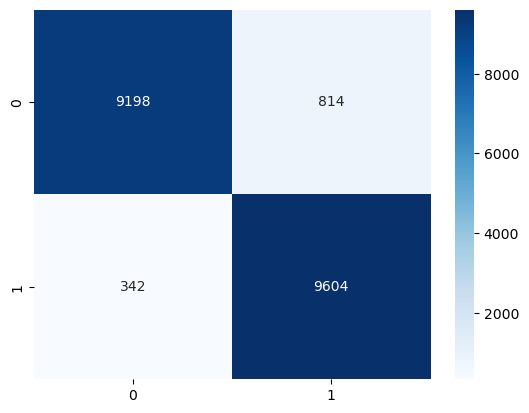

In [156]:
print("Train: \n", sns.heatmap(train_cf, annot = True, fmt = 'g', cmap='Blues'))

Test: 
 Axes(0.125,0.11;0.62x0.77)


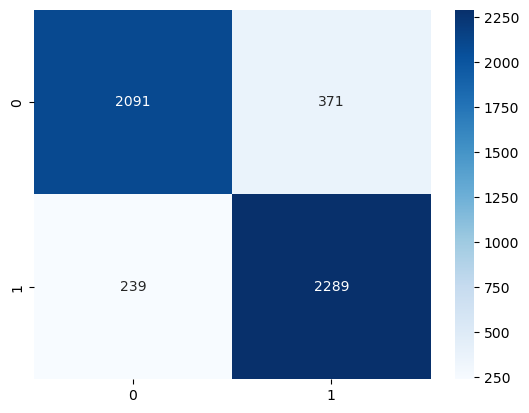

In [157]:
print("Test: \n", sns.heatmap(test_cf, annot = True, fmt = 'g', cmap='Blues'))

# Q8. Modularize your classifier (10 points)
1. Convert your code into a python module text_classifier.py

2. The user should be able to launch the application on command prompt using python test_classifier.py command. The module will automatically load the model paramters from a local file of your choice and be ready to take the input from user on command prompt. The program will preprocess user input, tokenize and predict the class.

3. Your module will take the input from user and output sentiment class in an indefinite loop. The output should printout the probabilities for each input token along with the final classification decision. Program will quit if user enters X.


In [158]:
vocab = []
for (x,y) in freqs.keys():
    if x not in vocab:
        vocab.append(x)
V = len(vocab)

In [159]:
#Write the parameters into parameters.txt file
with open('parameters.txt', 'w') as f:
  f.write(str(logprior) + '\n')
  f.write(str(loglikelihood) + '\n')
  f.write(str(freqs) + '\n')
  f.write(str(list(y_train)) + '\n')
  f.write(str(V))

# Q9. Theory Questions: (10 points)

1. Why is Laplace Smoothing or Additive Smoothing required while executing Naive Bayes operations, especially for text classification? Show how not having additive smoothing leads to bad outcomes by using an example of training and the test set. (10 points)


2. Why are logarithmic values computed instead of only probability values in the Naive Bayes algorithm? (5 points)

1.
Laplace Smoothing, also known as Additive Smoothing or Lidstone Smoothing, is crucial in Naive Bayes operations, especially for text classification. It is required to address the problem of zero probabilities that can occur when certain features (words in the case of text classification) are absent in either the training or test data. Let's explore why Laplace Smoothing is necessary and illustrate its importance with an example:

**Why Laplace Smoothing is Necessary:**

1. **Zero Probability Issue:** In Naive Bayes, we calculate conditional probabilities of features (words) given a class. When a feature does not occur in the training data of a particular class, its conditional probability becomes zero. This zero probability can have a significant impact when predicting the class of a test instance.

2. **Loss of Information:** If we encounter a word in the test data that was not present in the training data, the absence of smoothing would result in assigning zero probability to the entire class. This is problematic because it effectively ignores the evidence provided by other words present in the document, which can lead to incorrect classifications.

**Example Illustrating the Importance of Laplace Smoothing:**

Suppose we are building a binary spam email classifier with a simplified vocabulary consisting of only three words: "free," "buy," and "discount." We have a training dataset with the following spam and non-spam emails:

**Training Data:**

Spam Email 1: "Free offer! Buy now!"
Spam Email 2: "Discounts on everything!"
Non-Spam Email 1: "Meeting today."

Now, let's consider a test email:

**Test Data:**

Test Email: "Buy one get one free today."

Without Laplace Smoothing, the conditional probabilities for the words in the test email would be calculated as follows:

- P("Buy" | Spam) = 2/2 = 1.0 (occurs in all spam emails)
- P("One" | Spam) = 0/2 = 0.0 (never occurs in spam emails)
- P("Free" | Spam) = 1/2 = 0.5 (occurs in one spam email)
- P("Today" | Spam) = 0/2 = 0.0 (never occurs in spam emails)

The overall probability of the test email being spam is calculated as the product of these probabilities:

P(Spam | Test Email) = P("Buy" | Spam) * P("One" | Spam) * P("Free" | Spam) * P("Today" | Spam) = 1.0 * 0.0 * 0.5 * 0.0 = 0.0

Without Laplace Smoothing, the classifier assigns a probability of 0.0 to the spam class, indicating that it will classify the test email as non-spam, which is incorrect.

By contrast, with Laplace Smoothing, even for words not seen in the training data, there would be a small non-zero probability assigned, preventing the issue of zero probabilities and leading to more reasonable and accurate classifications. Laplace Smoothing ensures that the model does not discard valuable information when encountering previously unseen features in text classification tasks.

2.
Logarithmic values are computed in the Naive Bayes algorithm for several important reasons:

1. **Numerical Stability:**
   - When calculating conditional probabilities in Naive Bayes, especially with text data, the probabilities of individual features (words) can become very small, approaching zero.
   - Multiplying many small probabilities together can lead to numerical instability due to floating-point precision limitations. The result may be rounded to zero (underflow) or lose significant digits, leading to inaccurate calculations.

2. **Avoiding Underflow:**
   - Taking the logarithm of probabilities simplifies the multiplication of probabilities into addition. In other words, instead of multiplying probabilities, we add their logarithmic values. This reduces the risk of underflow.
   - Logarithms compress a wide range of values into a more manageable range, making it easier to work with very small or very large probabilities.

3. **Computation Efficiency:**
   - Calculating probabilities by addition (using logarithms) is computationally more efficient than performing numerous multiplications, especially when dealing with large datasets or high-dimensional feature spaces.
   - Logarithmic values require fewer computational resources and are faster to compute.

4. **Numerical Precision:**
   - Storing very small probabilities in floating-point representation can lead to precision issues, as floating-point numbers have limited precision. This can result in a loss of accuracy in the calculations.
   - Logarithmic values help maintain numerical precision by reducing the range of possible values.

5. **Ease of Interpretation:**
   - Logarithmic values are easier to interpret in terms of their magnitudes. A negative log value indicates a very small probability, while a positive log value represents a larger probability.
   - Log-likelihood ratios (differences between log probabilities) are commonly used for feature selection and model interpretation in Naive Bayes.
